In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def cv_evaluate(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error)
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    for key in cv_results.keys():
        if key in ['fit_time', 'score_time']:
            continue
        print(f"{key}: {cv_results[key]}")
        print(f"{key} trung bình: {cv_results[key].mean():.3f} ± {cv_results[key].std():.3f}")
        print()

In [4]:
pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()), ('svr', SVR())])

In [5]:
print_metrics(*evaluate_model(pipeline, X_train, y_train))

MSE: 3.389
MAE: 1.030
R2: 0.930


In [6]:
print_metrics(*evaluate_model(pipeline, X_test, y_test))

MSE: 3.589
MAE: 1.155
R2: 0.927


## Use validation set to optimize params

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

In [11]:
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['rbf', 'linear', 'poly'],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('te',
                                        TargetEncoder(cols=['nationality'])),
                                       ('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf', 'linear', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [12]:
print('Best params:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)

Best params: {'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Best score: -3.165979254258219


In [13]:
final_model = grid_search.best_estimator_

final_model.fit(X_train, y_train)

print("=== Đánh Giá Mô Hình SVR Sau Khi GridSearch ===")
print("Training Set:")
print_metrics(*evaluate_model(final_model, X_train, y_train))
print("\nTest Set:")
print_metrics(*evaluate_model(final_model, X_test, y_test))

=== Đánh Giá Mô Hình SVR Sau Khi GridSearch ===
Training Set:
MSE: 2.257
MAE: 0.644
R2: 0.953

Test Set:
MSE: 2.956
MAE: 0.986
R2: 0.940


In [14]:
svr = final_model.named_steps['svr']
svr

SVR(C=10, gamma='auto')

In [15]:
import joblib

joblib.dump(svr, 'svr_model.pkl')
print("Mô hình SVR đã được lưu thành công dưới tên 'svr_model.pkl'")

Mô hình SVR đã được lưu thành công dưới tên 'svr_model.pkl'


In [2]:
import joblib

svr = joblib.load('svr_model.pkl')

print("Mô hình SVR đã được tải lại thành công.")

Mô hình SVR đã được tải lại thành công.


In [6]:
pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('svr', svr)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()),
                ('svr', SVR(C=10, gamma='auto'))])

In [7]:
y_pred = pipeline.predict(X_test)

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [8]:
sorted_predictions_df = predictions_df.reset_index(drop=True)
print(sorted_predictions_df.head(20))

    Actual  Predicted
0       60  60.761445
1       55  60.536069
2       64  63.602167
3       70  69.148013
4       52  52.228980
5       71  72.196696
6       70  70.393865
7       70  69.558528
8       67  71.471684
9       70  69.054851
10      69  70.471585
11      67  64.142674
12      68  69.386873
13      66  66.024161
14      71  70.674103
15      72  72.949495
16      51  55.966913
17      70  70.447309
18      73  72.925418
19      74  73.935888


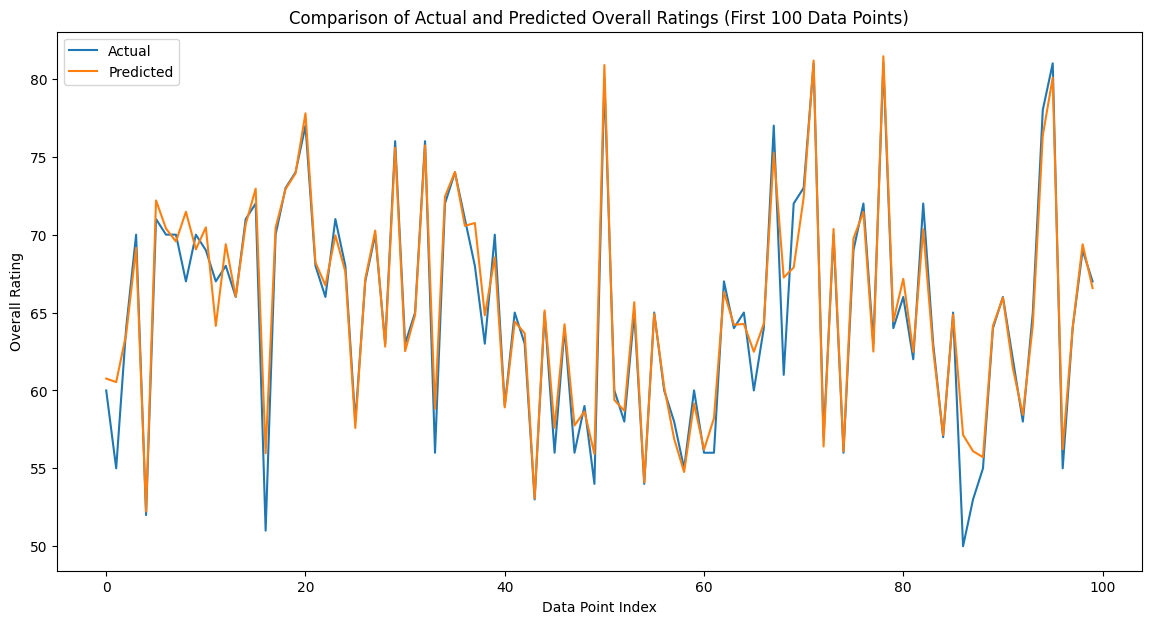

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(sorted_predictions_df['Actual'][:100].values, label='Actual')
plt.plot(sorted_predictions_df['Predicted'][:100].values, label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Overall Rating')
plt.title('Comparison of Actual and Predicted Overall Ratings (First 100 Data Points)')
plt.legend()
plt.show()